<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
from sklearn.metrics import make_scorer
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
start_len = len(data)

In [4]:
#Функция информации о таблицах
def check(df):

    print('Первые пять строк: \n', df.head())
    print('########################')
    print('Информация о талице: \n', df.info())
    print('########################')
    
    display(pd.DataFrame(round((df.isna().mean()*100),2), columns=['NaNs, %']).sort_values(by='NaNs, %', ascending=False).style.format(
    '{:.2f}').background_gradient('coolwarm'))
    print('########################')
    print('Количество дупликатов в таблице: \n', df.duplicated().sum())
    print('########################')

In [5]:
check(data)

Первые пять строк: 
            DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode 

,"NaNs, %"
NotRepaired,20.08
VehicleType,10.58
FuelType,9.28
Gearbox,5.60
Model,5.56
DateCrawled,0.00
Price,0.00
RegistrationYear,0.00
Power,0.00
Kilometer,0.00


########################
Количество дупликатов в таблице: 
 4
########################


In [6]:
#Удалим ненужные для обучения столбцы
data = data.drop(columns=['LastSeen', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode'])
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [7]:
data.columns = data.columns.str.lower()

price : [    0     1     2 ... 19998 19999 20000]



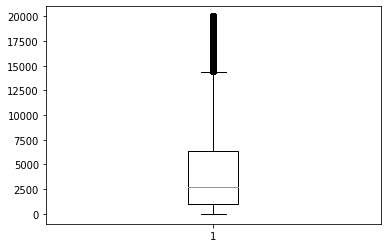

vehicletype : ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

registrationyear : [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]



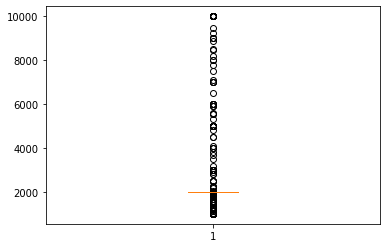

gearbox : ['auto' 'manual' nan]

power : [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   1

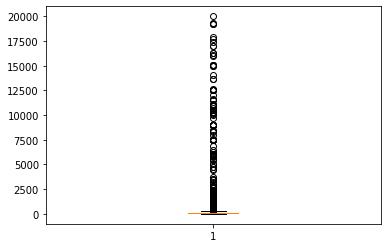

model : ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'im

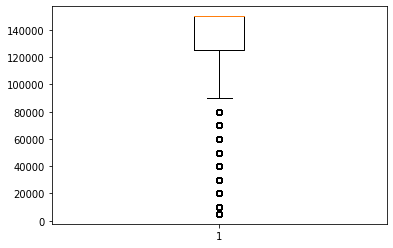

fueltype : ['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]

brand : ['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']

notrepaired : ['no' 'yes' nan]



In [8]:
#Посмотрим значения в колонках
def inf(col):
    for i in col:
        print(i, ':', data[i].sort_values().unique())
        print()
        if data[i].dtypes == 'int64':
            plt.boxplot(data[i])
            plt.show()
    
inf(data.columns)


Видно, что есть цены 0 и ниже 100 евро за машину, что маловероятно. В столбцах registrationyear, power есть аномальные значения В столбцах vehicletype, gearbox, model, fueltype, notrepaired заполним nan unknown

In [9]:
def fill(column):
    for i in column:
        data[i] = data[i].fillna('unknown')
fill(['vehicletype', 'notrepaired', 'fueltype', 'gearbox', 'model'])

In [10]:
check(data)

Первые пять строк: 
    price vehicletype  registrationyear gearbox  power    model  kilometer  \
0    480     unknown              1993  manual      0     golf     150000   
1  18300       coupe              2011  manual    190  unknown     125000   
2   9800         suv              2004    auto    163    grand     125000   
3   1500       small              2001  manual     75     golf     150000   
4   3600       small              2008  manual     69    fabia      90000   

   fueltype       brand notrepaired  
0    petrol  volkswagen     unknown  
1  gasoline        audi         yes  
2  gasoline        jeep     unknown  
3    petrol  volkswagen          no  
4  gasoline       skoda          no  
########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicl

,"NaNs, %"
price,0.00
vehicletype,0.00
registrationyear,0.00
gearbox,0.00
power,0.00
model,0.00
kilometer,0.00
fueltype,0.00
brand,0.00
notrepaired,0.00


########################
Количество дупликатов в таблице: 
 45040
########################


In [11]:
data = data.drop_duplicates()

In [12]:
data['price'].value_counts().sort_index()

0        8904
1        1075
2          12
3           7
4           1
         ... 
19995       9
19997       1
19998       5
19999     252
20000     223
Name: price, Length: 3731, dtype: int64

Видим, что много значений 0, и около него, так что рассмотрим до 100 евро

In [13]:
data[data['price']<100]['price'].value_counts().sort_index()

0     8904
1     1075
2       12
3        7
4        1
5       26
7        3
8        6
9        7
10      81
11       5
12       7
13       7
14       5
15      26
16       2
17       5
18       3
19       3
20      49
21       1
24       1
25      33
26       1
27       1
29       2
30      55
32       1
33       1
35      18
38       1
39       6
40      40
45      16
47       1
49      11
50     316
55      20
58       1
59       5
60      58
65      17
66       1
69       3
70      67
74       1
75      52
77       1
79       4
80     140
85      11
88       1
89       2
90      39
95      13
98       2
99     104
Name: price, dtype: int64

<AxesSubplot:>

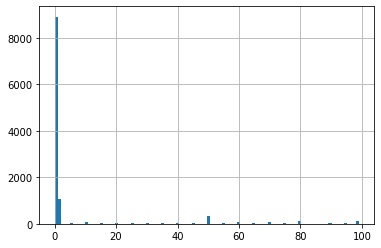

In [14]:
data[data['price']<100]['price'].hist(bins = 100)

In [15]:
#Удалим строки, где price <1
data = data[data['price']>1]

In [16]:
data['power'].value_counts().sort_index()

0        32552
1           24
2            9
3            9
4           26
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 698, dtype: int64

Видим, что много строк, где мощность равна нулю или около него, так же есть выборы, где мощность более 1000

<AxesSubplot:>

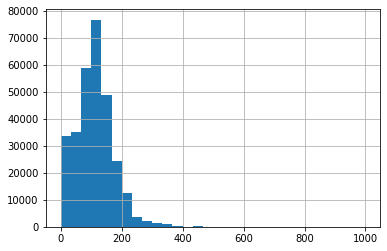

In [17]:
data[data['power']<1000]['power'].hist(bins = 30)

Видим, что больше 450 мощности - это выбросы

In [18]:
#Количество строк с мощностью меньше 10 и больше 450
len(data[(data['power']>450) | (data['power']<10)]['power'])

33232

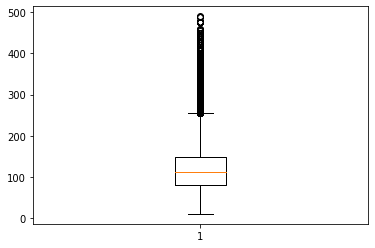

In [19]:
data = data[(data['power']<500) & (data['power']>10)]
plt.boxplot(data['power'])
plt.show()

In [20]:
data['registrationyear'].value_counts().sort_index()

1000    2
1234    1
1500    1
1800    2
1910    5
       ..
5000    6
5911    1
6000    2
8200    1
9999    1
Name: registrationyear, Length: 105, dtype: int64

<AxesSubplot:>

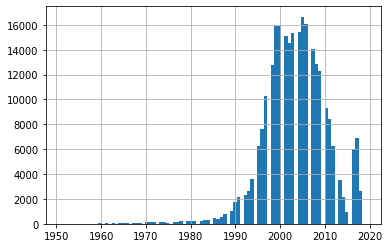

In [21]:
data[(data['registrationyear']>1950) & (data['registrationyear']<2022)]['registrationyear'].hist(bins = 90)

In [22]:
data = data[(data['registrationyear']>1960) & (data['registrationyear']<2016)]

In [23]:
check(data)

Первые пять строк: 
    price vehicletype  registrationyear gearbox  power    model  kilometer  \
1  18300       coupe              2011  manual    190  unknown     125000   
2   9800         suv              2004    auto    163    grand     125000   
3   1500       small              2001  manual     75     golf     150000   
4   3600       small              2008  manual     69    fabia      90000   
5    650       sedan              1995  manual    102      3er     150000   

   fueltype       brand notrepaired  
1  gasoline        audi         yes  
2  gasoline        jeep     unknown  
3    petrol  volkswagen          no  
4  gasoline       skoda          no  
5    petrol         bmw         yes  
########################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 250378 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             250378 non-null  int64 
 1   vehicl

,"NaNs, %"
price,0.00
vehicletype,0.00
registrationyear,0.00
gearbox,0.00
power,0.00
model,0.00
kilometer,0.00
fueltype,0.00
brand,0.00
notrepaired,0.00


########################
Количество дупликатов в таблице: 
 0
########################


In [24]:
print('Удалено данных:', f"{1-len(data)/start_len:.2%}", 'или', start_len- len(data), 'строк')

Удалено данных: 29.35% или 103991 строк


### Подготовка к обучению

Так как в столбце model много значений, то преобразуем его методом ordinal, а остальные методом OHE

In [30]:
#Преобразуем столбец model
encoder = OrdinalEncoder()
encoder.fit(data[['model']])
data['model'] = encoder.transform(data[['model']])

In [34]:
#Преобразуем остальные категории в числа
one_hot_list = ['vehicletype','gearbox', 'fueltype', 'brand', 'notrepaired']
df = data.copy()
tenure_one_hot = pd.get_dummies(df[one_hot_list], drop_first=True)
df = df.drop(one_hot_list,axis = 1)
df = df.join(tenure_one_hot, how='left')
df

,price,registrationyear,power,model,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
1,18300,2011,190,227.0,125000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,117.0,125000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,116.0,150000,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,101.0,90000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,11.0,150000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,2004,55,101.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
354362,3200,2004,225,140.0,150000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,106.0,125000,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,223.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [35]:
features = df.drop("price", axis=1)
target = df["price"]

In [36]:
#Отделение тестовой части
x, features_test, y, target_test = train_test_split(features, target, test_size=0.2, train_size=0.8)

In [37]:
#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(x, y, test_size = 0.25, train_size =0.75)

In [38]:
#Скалирование
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

In [39]:
#Преобразуем nparray в dataframe
def nptodf(data, ind, column):
    frame = pd.DataFrame(data, index = ind.index, columns = column.columns)
    return frame
features_train_scaled = nptodf(features_train_scaled, target_train, features)
features_valid_scaled = nptodf(features_valid_scaled, target_valid, features)
features_test_scaled = nptodf(features_test_scaled, target_test, features)

In [40]:
#Проверка разделения
def check(data):
    res = len(data)/len(df)
    print('Процент выборки:', res, ', Количество строк и столбцов:', data.shape)
    
data_list = [features_train_scaled, features_valid_scaled, target_train, target_valid, features_test_scaled, target_test]
for i in data_list:
    check(i)

Процент выборки: 0.5999968048310954 , Количество строк и столбцов: (150226, 62)
Процент выборки: 0.2000015975844523 , Количество строк и столбцов: (50076, 62)
Процент выборки: 0.5999968048310954 , Количество строк и столбцов: (150226,)
Процент выборки: 0.2000015975844523 , Количество строк и столбцов: (50076,)
Процент выборки: 0.2000015975844523 , Количество строк и столбцов: (50076, 62)
Процент выборки: 0.2000015975844523 , Количество строк и столбцов: (50076,)


### Вывод

- Были загружены и исследованы данные
- Удалены аномальные значения, выбросы, лишние признаки
- Было произведено encoding категориальных значений
- Было произведено разделение выборок и их скалирование

## Обучение моделей

In [41]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

### LinearRegression

In [42]:
model_lr = LinearRegression().fit(features_train_scaled, target_train)
lr_pred = model_lr.predict(features_valid_scaled)
rmse_lr = np.sqrt(mse(target_valid, lr_pred))
print('RMSE LinearRegression:', rmse_lr)

RMSE LinearRegression: 2744.3311436110585


In [43]:
%%time
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model_lr,parameters, cv=4, scoring = rmse_score, verbose=2)
grid.fit(features_train_scaled, target_train)
grid.best_params_

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] END ....copy_X=True, fit_intercept=True, normalize=True; total time=   1.4s
[CV] END ....copy_X=True, fit_intercept=True, normalize=True; total time=   1.5s
[CV] END ....copy_X=True, fit_intercept=True, normalize=True; total time=   1.4s
[CV] END ....copy_X=True, fit_intercept=True, normalize=True; total time=   1.6s
[CV] END ...copy_X=True, fit_intercept=True, normalize=False; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=True, normalize=False; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=True, normalize=False; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=True, normalize=False; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=False, normalize=True; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=False, normalize=True; total time=   1.4s
[CV] END ...copy_X=True, fit_intercept=False, normalize=True; total time=   1.3s
[CV] END ...copy_X=True, fit_intercept=False, nor

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [44]:
%%time
lr_tuned = LinearRegression(**grid.best_params_).fit(features_train_scaled, target_train)

CPU times: user 1.23 s, sys: 671 ms, total: 1.9 s
Wall time: 1.91 s


In [45]:
%%time
lr_pred = lr_tuned.predict(features_valid_scaled)

CPU times: user 9.76 ms, sys: 3.26 ms, total: 13 ms
Wall time: 5.21 ms


In [46]:
rmse_lr_tuned = np.sqrt(mse(target_valid, lr_pred))
print("LinearRegression RMSE: %.2f" % rmse_lr_tuned) 

LinearRegression RMSE: 2744.33


In [88]:
importances_lr = pd.DataFrame(data={
    'Attribute': features_train_scaled.columns,
    'Importance': lr_tuned.coef_
})
importances_lr = importances_lr.sort_values(by='Importance', ascending=False)

In [89]:
plt.rcParams["figure.figsize"] = (20,8)

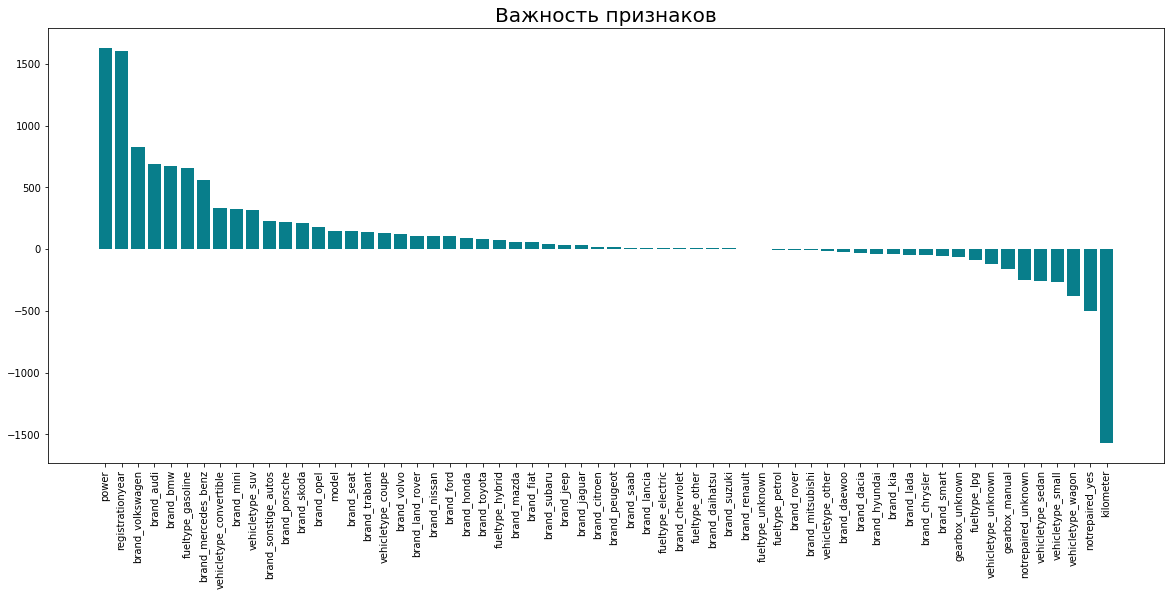

In [90]:
plt.bar(x=importances_lr['Attribute'], height=importances_lr['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

### LightGBM

In [47]:
%%time
lgb_model = LGBMRegressor().fit(features_train_scaled, target_train)
y_pred = lgb_model.predict(features_valid_scaled)
rmse_lgbm = np.sqrt(mse(target_valid, y_pred))
print('RMSE LightGBM:', rmse_lgbm)

RMSE LightGBM: 1671.3396851939362
CPU times: user 5.88 s, sys: 0 ns, total: 5.88 s
Wall time: 5.91 s


In [48]:
%%time
lgbm_params = {"n_estimators": [1000, 1200],
               "max_depth": [12, 14]
              }

lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=4,
                             scoring = rmse,
                             n_jobs=-1,
                             verbose=2).fit(features_train_scaled, target_train)

lgbm_cv_model.best_params_

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ....................max_depth=12, n_estimators=1000; total time=  31.8s
[CV] END ....................max_depth=12, n_estimators=1000; total time=  25.1s
[CV] END ....................max_depth=12, n_estimators=1000; total time=  24.2s
[CV] END ....................max_depth=12, n_estimators=1000; total time=  28.9s
[CV] END ....................max_depth=12, n_estimators=1200; total time=  29.8s
[CV] END ....................max_depth=12, n_estimators=1200; total time= 2.8min
[CV] END ....................max_depth=12, n_estimators=1200; total time=  37.2s
[CV] END ....................max_depth=12, n_estimators=1200; total time=  29.7s
[CV] END ....................max_depth=14, n_estimators=1000; total time=  27.7s
[CV] END ....................max_depth=14, n_estimators=1000; total time=  30.0s
[CV] END ....................max_depth=14, n_estimators=1000; total time=  35.9s
[CV] END ....................max_depth=14, n_esti

{'max_depth': 12, 'n_estimators': 1000}

In [49]:
%%time
lgbm_tuned = LGBMRegressor(**lgbm_cv_model.best_params_).fit(features_train_scaled, target_train)

CPU times: user 29.2 s, sys: 218 ms, total: 29.4 s
Wall time: 29.6 s


In [50]:
%%time
y_pred = lgbm_tuned.predict(features_valid_scaled)

CPU times: user 4.99 s, sys: 10.9 ms, total: 5 s
Wall time: 4.96 s


In [51]:
rmse_lgb = np.sqrt(mse(target_valid, y_pred))
print("RMSE: %.2f" % rmse_lgb) 

RMSE: 1572.38


In [92]:
importances_lgb = pd.DataFrame(data={
    'Attribute': features_train_scaled.columns,
    'Importance': lgbm_tuned.feature_importances_
})
importances_lgb = importances_lgb.sort_values(by='Importance', ascending=False)

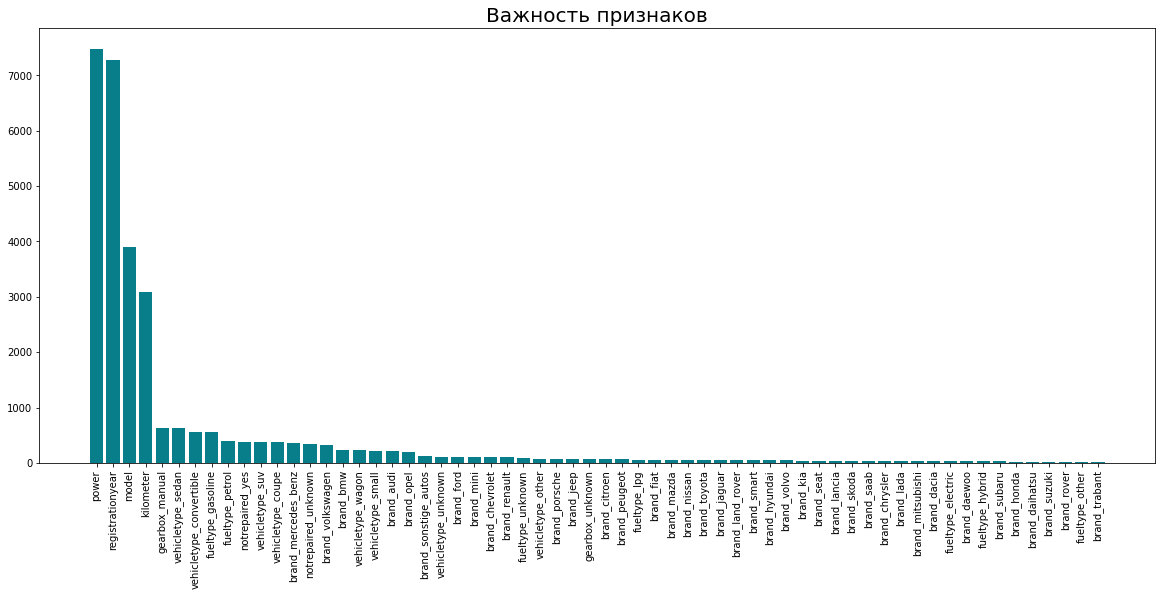

In [93]:
plt.bar(x=importances_lgb['Attribute'], height=importances_lgb['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Catboost

In [52]:
%%time
cbr_model = CatBoostRegressor().fit(features_train_scaled, target_train)

Learning rate set to 0.090387
0:	learn: 4390.5992191	total: 71.6ms	remaining: 1m 11s
1:	learn: 4131.4962914	total: 93.1ms	remaining: 46.4s
2:	learn: 3902.5996134	total: 114ms	remaining: 37.9s
3:	learn: 3700.2952287	total: 134ms	remaining: 33.4s
4:	learn: 3518.5989049	total: 154ms	remaining: 30.6s
5:	learn: 3356.5625268	total: 176ms	remaining: 29.1s
6:	learn: 3216.4953022	total: 196ms	remaining: 27.7s
7:	learn: 3089.7396944	total: 216ms	remaining: 26.8s
8:	learn: 2976.9427577	total: 235ms	remaining: 25.9s
9:	learn: 2876.0196170	total: 254ms	remaining: 25.2s
10:	learn: 2782.5998130	total: 275ms	remaining: 24.7s
11:	learn: 2701.2623294	total: 296ms	remaining: 24.3s
12:	learn: 2630.2004623	total: 316ms	remaining: 24s
13:	learn: 2570.4810743	total: 337ms	remaining: 23.7s
14:	learn: 2513.6902032	total: 357ms	remaining: 23.5s
15:	learn: 2462.7805315	total: 377ms	remaining: 23.2s
16:	learn: 2419.7775415	total: 398ms	remaining: 23s
17:	learn: 2379.9753331	total: 417ms	remaining: 22.8s
18:	learn

In [57]:
%%time
cbr_pred = cbr_model.predict(features_valid_scaled)

CPU times: user 62.7 ms, sys: 154 µs, total: 62.8 ms
Wall time: 61 ms


In [58]:
rmse_cbr = np.sqrt(mse(target_valid, cbr_pred))
print('RMSE CatBoostRegressor:', rmse_cbr)

RMSE CatBoostRegressor: 1598.3085777568895


In [55]:
%%time
parameters_cb = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]
              }
model_CBR = CatBoostRegressor(loss_function='RMSE', eval_metric = 'RMSE', verbose = 100)
cb_model = GridSearchCV(estimator = model_CBR, param_grid = parameters_cb, cv = 4, n_jobs=-1, scoring=rmse)
cb_model.fit(features_train_scaled, target_train)
cb_model.best_params_

0:	learn: 4577.5512554	total: 18.5ms	remaining: 18.4s
100:	learn: 2055.0036356	total: 1.53s	remaining: 13.6s
200:	learn: 1851.3261365	total: 2.98s	remaining: 11.8s
300:	learn: 1775.4916692	total: 4.42s	remaining: 10.3s
400:	learn: 1729.8723971	total: 5.87s	remaining: 8.77s
500:	learn: 1694.1532437	total: 7.37s	remaining: 7.34s
600:	learn: 1669.1346825	total: 8.84s	remaining: 5.87s
700:	learn: 1649.2735770	total: 10.3s	remaining: 4.41s
800:	learn: 1632.2511882	total: 11.8s	remaining: 2.92s
900:	learn: 1617.4752611	total: 13.2s	remaining: 1.45s
999:	learn: 1604.7736263	total: 14.6s	remaining: 0us
0:	learn: 4577.3467252	total: 15.7ms	remaining: 15.6s
100:	learn: 2060.7849710	total: 1.56s	remaining: 13.9s
200:	learn: 1855.5467966	total: 3.1s	remaining: 12.3s
300:	learn: 1780.2333941	total: 4.53s	remaining: 10.5s
400:	learn: 1732.7029168	total: 5.99s	remaining: 8.95s
500:	learn: 1699.0381610	total: 7.41s	remaining: 7.38s
600:	learn: 1673.9941118	total: 8.83s	remaining: 5.87s
700:	learn: 165

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [56]:
%%time
cb_tuned = CatBoostRegressor(**cb_model.best_params_).fit(features_train_scaled, target_train)

0:	learn: 4579.1458150	total: 31.6ms	remaining: 31.6s
1:	learn: 4485.9955067	total: 55ms	remaining: 27.4s
2:	learn: 4395.0260280	total: 79.7ms	remaining: 26.5s
3:	learn: 4310.0941079	total: 101ms	remaining: 25.1s
4:	learn: 4225.9421094	total: 125ms	remaining: 24.8s
5:	learn: 4146.3648712	total: 149ms	remaining: 24.7s
6:	learn: 4069.8735532	total: 175ms	remaining: 24.8s
7:	learn: 3995.1593492	total: 201ms	remaining: 24.9s
8:	learn: 3923.5480488	total: 223ms	remaining: 24.5s
9:	learn: 3854.2689686	total: 244ms	remaining: 24.2s
10:	learn: 3787.4795926	total: 266ms	remaining: 23.9s
11:	learn: 3722.5575298	total: 288ms	remaining: 23.7s
12:	learn: 3661.1366155	total: 308ms	remaining: 23.4s
13:	learn: 3602.2509072	total: 332ms	remaining: 23.4s
14:	learn: 3545.1057270	total: 354ms	remaining: 23.2s
15:	learn: 3489.7376389	total: 376ms	remaining: 23.1s
16:	learn: 3437.1860756	total: 398ms	remaining: 23s
17:	learn: 3386.2760276	total: 419ms	remaining: 22.9s
18:	learn: 3336.3537213	total: 441ms	re

In [59]:
%%time
y_pred_cat = cb_tuned.predict(features_valid_scaled)

CPU times: user 68.4 ms, sys: 206 µs, total: 68.6 ms
Wall time: 67.1 ms


In [60]:
cbr_rmse = np.sqrt(mse(target_valid, y_pred_cat))
print("RMSE: %.2f" % cbr_rmse) 

RMSE: 1658.06


In [94]:
importances_cat = pd.DataFrame(data={
    'Attribute': features_train_scaled.columns,
    'Importance': cb_tuned.feature_importances_
})
importances_cat = importances_cat.sort_values(by='Importance', ascending=False)

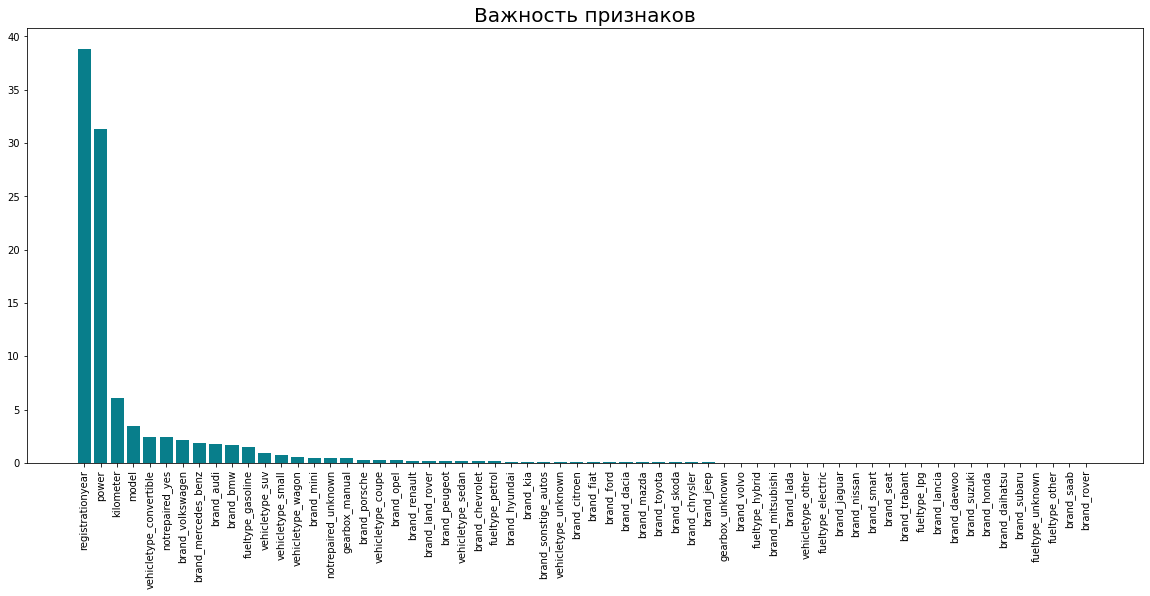

In [95]:
plt.bar(x=importances_cat['Attribute'], height=importances_cat['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Анализ моделей

In [63]:
print('LinearRegression:', end = '')
print()
print(f'RMSE:{rmse_lr_tuned}, скорость предсказания: 13 ms, время обучения: 1.9 s')
print('LightGBM:', end = '')
print()
print(f'RMSE:{rmse_lgb}, скорость предсказания: 5 s, время обучения: 29.4 s')
print('Catboost:', end = '')
print()
print(f'RMSE:{cbr_rmse}, скорость предсказания: 68.6 ms, время обучения: 21 s')

LinearRegression:
RMSE:2744.331143611059, скорость предсказания: 13 ms, время обучения: 1.9 s
LightGBM:
RMSE:1572.3783433280976, скорость предсказания: 5 s, время обучения: 29.4 s
Catboost:
RMSE:1658.0570329370557, скорость предсказания: 68.6 ms, время обучения: 21 s


Лучшая модель - LighGBM

In [96]:
%%time
final_lgb_pred = lgbm_tuned.predict(features_test_scaled)

CPU times: user 5.03 s, sys: 8.91 ms, total: 5.04 s
Wall time: 4.97 s


In [97]:
final_lgb_rmse = np.sqrt(mse(target_test, final_lgb_pred))
print("RMSE: %.2f" % final_lgb_rmse)

RMSE: 1578.86


## Вывод

- В данных были пропуски, лишние признаки, аномальные значения и выбросы
- Было обучено две модели градиентного бустинга и одна регрессии
- Наилучшая модель по времени - catboost
- Наилучшая модель по RMSE - lightgbm
- Худшая модель по всем показателям - linearregression